In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score 

plt.style.use('ggplot')
sns.set_palette("viridis") 
plt.rcParams['figure.figsize'] = (12, 8) 

import warnings
warnings.filterwarnings('ignore') 

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


In [2]:

df = pd.read_csv('clustering.csv')


In [3]:

df_processed = df.copy()
new_columns = {}
aylar_kisa = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
aylar_uzun = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
new_columns['Year'] = 'year'
new_columns['longitude'] = 'longitude'
new_columns['latitude'] = 'latitude'
new_columns['Total'] = 'total_tuketim'
for i, ay_uzun in enumerate(aylar_uzun):
   
    kur_col_old = f"{ay_uzun} usd/tr"
    if kur_col_old in df_processed.columns:
        new_columns[kur_col_old] = f"{aylar_kisa[i]}_kur"
    
    tuketim_col_old = ay_uzun
    if tuketim_col_old in df_processed.columns:
         new_columns[tuketim_col_old] = f"{aylar_kisa[i]}_tuketim"

df_processed.rename(columns=new_columns, inplace=True)



aylik_kur_sutunlari = [col for col in df_processed.columns if col.endswith('_kur')]
aylik_tuketim_sutunlari = [col for col in df_processed.columns if col.endswith('_tuketim') and col != 'total_tuketim']




for col in aylik_tuketim_sutunlari:
    
    neg_count = (df_processed[col] < 0).sum()
    if neg_count > 0:
        print(f"'{col}' sütununda {neg_count} adet negatif değer bulundu ve 0 ile değiştiriliyor.")
    df_processed[col] = df_processed[col].apply(lambda x: 0 if x < 0 else x)


if 'total_tuketim' in df_processed.columns:
     neg_count_total = (df_processed['total_tuketim'] < 0).sum()
     if neg_count_total > 0:
         print(f"'total_tuketim' sütununda {neg_count_total} adet negatif değer bulundu ve 0 ile değiştiriliyor.")
         df_processed['total_tuketim'] = df_processed['total_tuketim'].apply(lambda x: 0 if x < 0 else x)


print("\nEksik veriler dolduruluyor (Medyan ile)...")
for col in aylik_tuketim_sutunlari:
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"'{col}' sütunundaki eksik değerler {median_val:.2f} (medyan) ile dolduruldu.")




df_processed['hesaplanan_total'] = df_processed[aylik_tuketim_sutunlari].sum(axis=1)
df_processed['total_fark'] = df_processed['total_tuketim'] - df_processed['hesaplanan_total']





'may_tuketim' sütununda 3 adet negatif değer bulundu ve 0 ile değiştiriliyor.
'nov_tuketim' sütununda 1 adet negatif değer bulundu ve 0 ile değiştiriliyor.

Eksik veriler dolduruluyor (Medyan ile)...
'jan_tuketim' sütunundaki eksik değerler 182.86 (medyan) ile dolduruldu.
'feb_tuketim' sütunundaki eksik değerler 155.62 (medyan) ile dolduruldu.
'mar_tuketim' sütunundaki eksik değerler 127.93 (medyan) ile dolduruldu.
'apr_tuketim' sütunundaki eksik değerler 82.02 (medyan) ile dolduruldu.
'may_tuketim' sütunundaki eksik değerler 30.60 (medyan) ile dolduruldu.
'jun_tuketim' sütunundaki eksik değerler 19.43 (medyan) ile dolduruldu.
'jul_tuketim' sütunundaki eksik değerler 12.83 (medyan) ile dolduruldu.
'aug_tuketim' sütunundaki eksik değerler 9.00 (medyan) ile dolduruldu.
'sep_tuketim' sütunundaki eksik değerler 11.59 (medyan) ile dolduruldu.
'oct_tuketim' sütunundaki eksik değerler 18.13 (medyan) ile dolduruldu.
'nov_tuketim' sütunundaki eksik değerler 56.70 (medyan) ile dolduruldu.


İlk başta df_processed = df.copy() ile orijinal datanın bir yedeğini aldım. Böylece orijinal veriyi bozmama garantisi var, eğer bir şeyleri yanlış yaparsam diye.
Eski sütun isimleri biraz karışıktı (Jan, Feb, Jan usd/tr falan). Bunları daha anlaşılır ve bilgisayarın seveceği hale getirmek istedim.
Sonra aylar için bir döngü kurdum. aylar_uzun (Jan, Feb...) listesindeki her ay içi. En sonda df_processed.rename(columns=new_columns, inplace=True) ile bütün bu belirlediğim yeni isimleri dataya uyguladım.
Tüketim negatif olamaz mantıken. Bütün aylık tüketim sütunlarını (aylik_tuketim_sutunlari) tek tek gezdim. Eğer bir sütunda negatif değer varsa, kaç tane olduğunu yazdırdım ve hepsini 0 yaptım. Aynı şeyi total_tuketim sütunu için de yaptım.
Yine aylık tüketim sütunlarını gezdim. Eğer bir sütunda boşluk (yani NaN) varsa:
O sütunun medyanını (yani ortadaki değerini) hesapladım.
Bütün boşlukları (NaN) bulduğum bu medyan değeriyle doldurdum. Medyan kullanmak iyi çünkü aşırı uç değerlerden çok etkilenmiyor. Hangi sütunu doldurduğumu ve hangi medyanı kullandığımı da ekrana yazdırdım.

In [4]:

df_processed['total_tuketim'] = df_processed['hesaplanan_total']


df_processed.drop(columns=['hesaplanan_total', 'total_fark'], inplace=True)


zero_total_count = (df_processed['total_tuketim'] == 0).sum()
print(f"'total_tuketim' değeri 0 olan satır sayısı: {zero_total_count}")

print("\n'total_tuketim' güncellendi ve yardımcı sütunlar kaldırıldı.")


'total_tuketim' değeri 0 olan satır sayısı: 0

'total_tuketim' güncellendi ve yardımcı sütunlar kaldırıldı.


In [ ]:

tuketim_cols = aylik_tuketim_sutunlari 

percent_cols = [f"{col}_percent" for col in tuketim_cols]


df_zero_total = df_processed[df_processed['total_tuketim'] == 0].copy()
df_analysis = df_processed[df_processed['total_tuketim'] > 0].copy()

print(f"Analiz için {len(df_analysis)} satır (toplam tüketim > 0).")
if not df_zero_total.empty:
    print(f"Toplam tüketimi 0 olan {len(df_zero_total)} satır geçici olarak ayrıldı.")

for i, col in enumerate(tuketim_cols):
    df_analysis[percent_cols[i]] = (df_analysis[col] / df_analysis['total_tuketim']) * 100


df_analysis['percent_sum_check'] = df_analysis[percent_cols].sum(axis=1)
print("\nHesaplanan yüzdelerin satır bazında toplamının özeti:")
display(df_analysis['percent_sum_check'].describe())



X_task1 = df_analysis[percent_cols].copy()
scaler_task1 = StandardScaler()
X_task1_scaled = scaler_task1.fit_transform(X_task1)


Analiz için 215871 satır (toplam tüketim > 0).

Hesaplanan yüzdelerin satır bazında toplamının özeti:


count    2.158710e+05
mean     1.000000e+02
std      1.499374e-14
min      1.000000e+02
25%      1.000000e+02
50%      1.000000e+02
75%      1.000000e+02
max      1.000000e+02
Name: percent_sum_check, dtype: float64

Sıfırları ayıkladım, aylık tüketimlerin yüzdesini hesapladım, toplamı kontrol ettim, sadece yüzdeleri aldıö ve analiz için ölçeklediö.


Optimal küme sayısı belirleniyor (k=2 ile 3 arası deneniyor)...
Silhouette Score hesaplamasında sample_size=50000 kullanılacak (veya tüm veri, hangisi daha küçükse).
k=2: WCSS = 2062387.61, Silhouette Score = 0.3993 (Hesaplama süresi: 36.05 s, Silhouette süresi: 35.45 s)
k=3: WCSS = 1695182.53, Silhouette Score = 0.4332 (Hesaplama süresi: 37.81 s, Silhouette süresi: 36.86 s)

Hesaplamalar tamamlandı.
Toplam hesaplama süresi: 73.87 saniye.


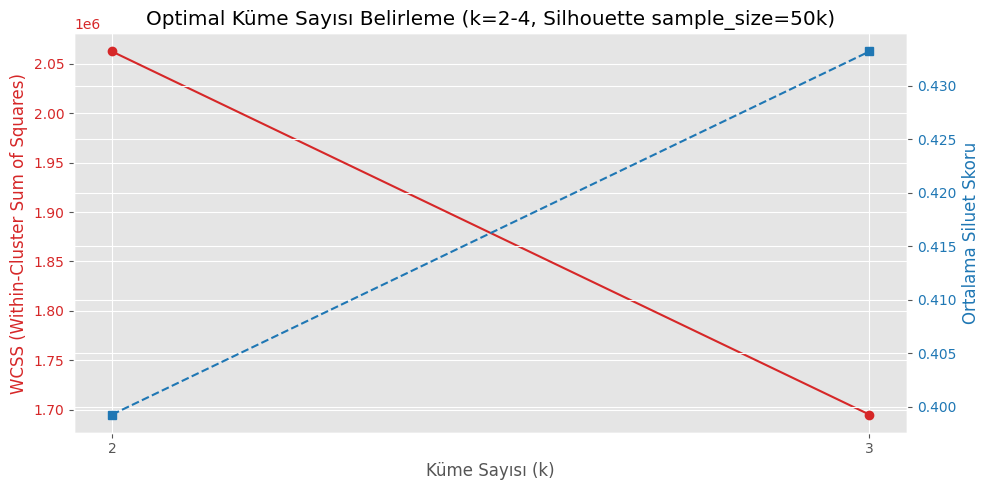


Test Edilen Aralıkta (2-3) En Yüksek Ortalama Siluet Skoru: 0.4332 (k=3)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time # Zaman ölçümü için eklendi


import numpy as np
from sklearn.preprocessing import StandardScaler



wcss = []
silhouette_scores = []


k_range = range(2, 4)


start_time = time.time()

print(f"\nOptimal küme sayısı belirleniyor (k={k_range.start} ile {k_range.stop-1} arası deneniyor)...")
print(f"Silhouette Score hesaplamasında sample_size=50000 kullanılacak (veya tüm veri, hangisi daha küçükse).")

if X_task1_scaled.shape[0] < 2:
     print("UYARI: Kümeleme için yeterli veri noktası yok (en az 2 gerekli). Kümeleme adımı atlanıyor.")
else:
    for k in k_range:
         
        if k >= X_task1_scaled.shape[0]:
            print(f"k={k} atlanıyor: Küme sayısı ({k}), veri noktası sayısından ({X_task1_scaled.shape[0]}) fazla veya eşit olamaz.")
            
            continue 

        k_start_time = time.time() 

        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=13, max_iter=300)
        cluster_labels = kmeans_model.fit_predict(X_task1_scaled)

       
        wcss.append(kmeans_model.inertia_)

       
        sil_start_time = time.time()
        
        if 1 < len(np.unique(cluster_labels)) < X_task1_scaled.shape[0]:
             score = silhouette_score(X_task1_scaled, cluster_labels, metric='euclidean',
                                     sample_size=50000, random_state=13)
        else:
             print(f"k={k} için Siluet Skoru hesaplanamıyor (geçersiz küme sayısı veya tek küme oluştu). NaN olarak işaretleniyor.")
             score = np.nan 
        sil_end_time = time.time()
        silhouette_scores.append(score)

        k_end_time = time.time() 
        
        score_str = f"{score:.4f}" if not np.isnan(score) else "Hesaplanamadı"
        print(f"k={k}: WCSS = {wcss[-1]:.2f}, Silhouette Score = {score_str} "
              f"(Hesaplama süresi: {k_end_time - k_start_time:.2f} s, "
              f"Silhouette süresi: {sil_end_time - sil_start_time:.2f} s)")


    print("\nHesaplamalar tamamlandı.")
    total_time = time.time() - start_time
    print(f"Toplam hesaplama süresi: {total_time:.2f} saniye.")


   

   
    if not wcss or all(np.isnan(s) for s in silhouette_scores if s is not None):
        print("\nGrafik çizilemiyor: Yeterli WCSS veya Siluet Skoru verisi yok.")
    else:
        fig, ax1 = plt.subplots(figsize=(10, 5))

        
        color = 'tab:red'
        ax1.set_xlabel('Küme Sayısı (k)')
        ax1.set_ylabel('WCSS (Within-Cluster Sum of Squares)', color=color)

        valid_k_wcss = [k for i, k in enumerate(k_range) if i < len(wcss)]
        ax1.plot(valid_k_wcss, wcss, marker='o', linestyle='-', color=color, label='WCSS')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_title('Optimal Küme Sayısı Belirleme (k=2-4, Silhouette sample_size=50k)')
        ax1.grid(True)

        
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Ortalama Siluet Skoru', color=color)
        
        valid_k_silhouette = [k for i, k in enumerate(k_range) if i < len(silhouette_scores) and not np.isnan(silhouette_scores[i])]
        valid_scores = [s for s in silhouette_scores if not np.isnan(s)]
        if valid_k_silhouette: 
            ax2.plot(valid_k_silhouette, valid_scores, marker='s', linestyle='--', color=color, label='Silhouette Score (sample_size=50k)')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.xticks(list(k_range)) 
        plt.show()

        
        valid_scores_only = [s for s in silhouette_scores if not np.isnan(s)]
        if valid_scores_only:
            best_silhouette_score = max(valid_scores_only)
           
            best_score_index = silhouette_scores.index(best_silhouette_score)
            optimal_k_silhouette = k_range[best_score_index]
            print(f"\nTest Edilen Aralıkta ({k_range.start}-{k_range.stop-1}) En Yüksek Ortalama Siluet Skoru: {best_silhouette_score:.4f} (k={optimal_k_silhouette})")
        else:
            print("\nGeçerli Siluet Skoru hesaplanamadı.")

   
    


K değerlerini deneyerek silüet skoru hesapladım. Optimal küme 3 çıktı 

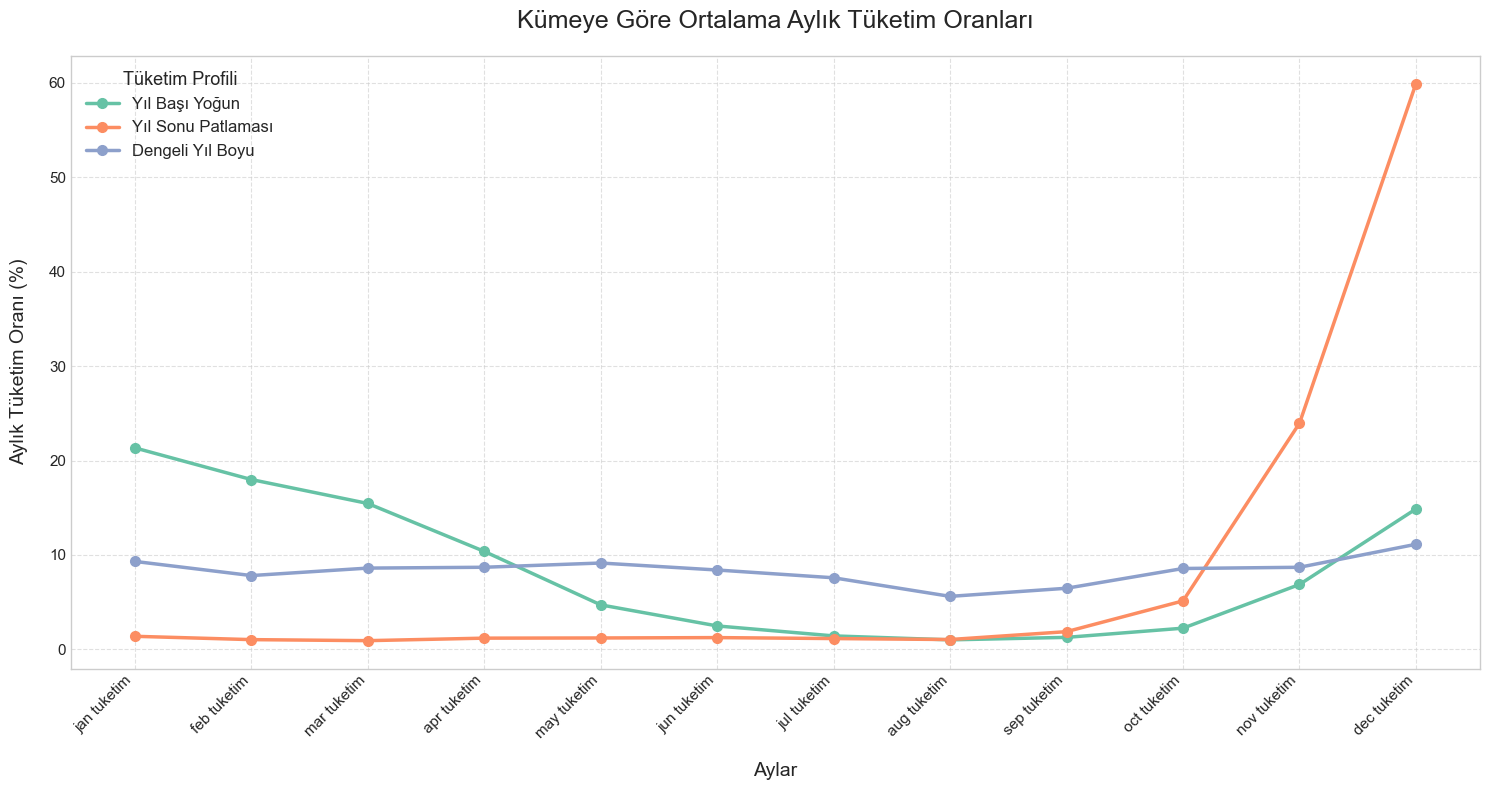


PCA ile boyut indirgeme yapılıyor...


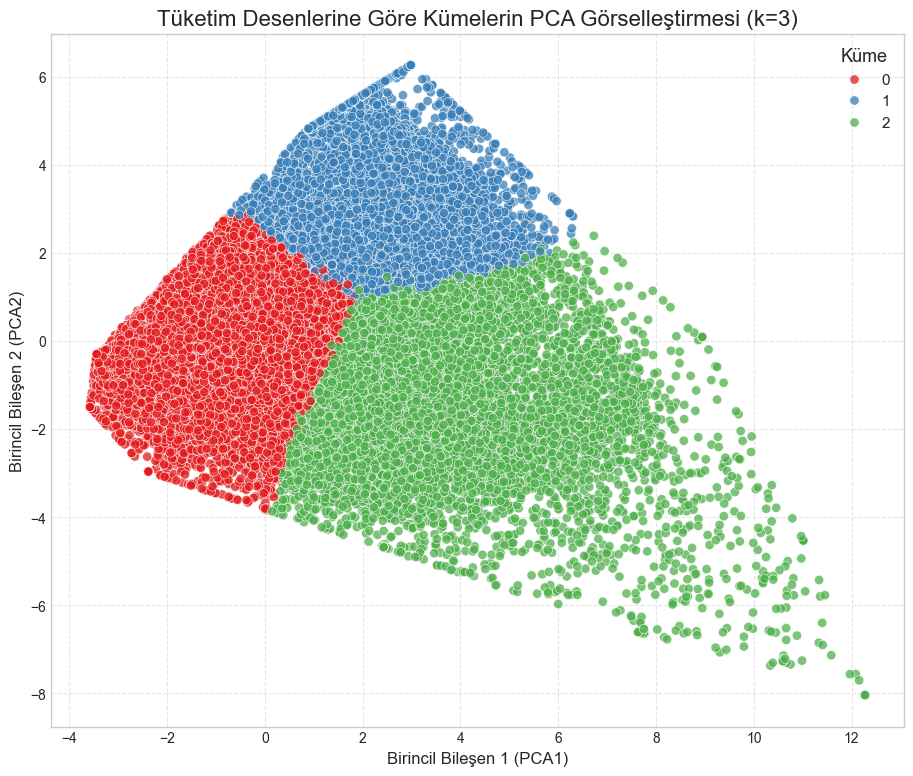

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.display import display
if ('df_cluster_centers_original' not in locals() or
    'optimal_k' not in locals() or
    'percent_cols' not in locals()):
    print("UYARI: Gerekli değişkenler bulunamadı. Örnek veriler oluşturuluyor...")
    optimal_k = 3
    n_samples_example = 500
    aylar = [f'Ay_{i+1}' for i in range(12)]
    percent_cols = [f'{ay}_percent' for ay in aylar]
    raw_data = np.random.rand(n_samples_example, 12) + 0.1 
    raw_data = raw_data / raw_data.sum(axis=1, keepdims=True) * 100
    X_task1_example = pd.DataFrame(raw_data, columns=percent_cols)
    df_analysis_example = X_task1_example.copy()
    scaler_task1 = StandardScaler()
    X_task1_scaled_example = scaler_task1.fit_transform(X_task1_example)
    kmeans_example = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=13)
    df_analysis_example['cluster_pattern'] = kmeans_example.fit_predict(X_task1_scaled_example)
    cluster_centers_original = scaler_task1.inverse_transform(kmeans_example.cluster_centers_)
    df_cluster_centers_original = pd.DataFrame(cluster_centers_original, columns=percent_cols)
    df_cluster_centers_original.index.name = 'Küme'
    df_analysis = df_analysis_example
    print("Örnek veriler kullanılıyor.")
    print("\nÖrnek Küme Merkezleri:")
    display(df_cluster_centers_original.round(2))




cluster_names = {
    0: "Yıl Başı Yoğun",   
    1: "Yıl Sonu Patlaması", 
    2: "Dengeli Yıl Boyu"   
   
}



plt.style.use('seaborn-v0_8-whitegrid') 


plt.figure(figsize=(15, 8)) 


palette = sns.color_palette('Set2', optimal_k)


try:
    
    x_labels = [col.replace('_percent', '').replace('_', ' ') for col in df_cluster_centers_original.columns]
except AttributeError:
     
    x_labels = df_cluster_centers_original.columns


for i in range(optimal_k):
    
    label_name = cluster_names.get(i, f'Küme {i}')
    plt.plot(x_labels,
             df_cluster_centers_original.iloc[i],
             marker='o',           
             markersize=7,        
             linestyle='-',        
             linewidth=2.5,       
             color=palette[i % len(palette)], 
             label=label_name)     


plt.title('Kümeye Göre Ortalama Aylık Tüketim Oranları', fontsize=18, pad=20)
plt.xlabel('Aylar', fontsize=14, labelpad=15)
plt.ylabel('Aylık Tüketim Oranı (%)', fontsize=14, labelpad=15) 
plt.xticks(rotation=45, ha='right', fontsize=11) 
plt.yticks(fontsize=11)
plt.legend(title='Tüketim Profili', title_fontsize='13', fontsize='12', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout()
plt.show()




print("\nPCA ile boyut indirgeme yapılıyor...")
pca = PCA(n_components=2, random_state=13) 
X_task1_pca = pca.fit_transform(X_task1_scaled)


df_analysis['pca1'] = X_task1_pca[:, 0]
df_analysis['pca2'] = X_task1_pca[:, 1]


plt.figure(figsize=(11, 9))


scatter = sns.scatterplot(
    data=df_analysis,
    x='pca1',
    y='pca2',
    hue='cluster_pattern', 
    palette='Set1',       
    s=45,                  
    alpha=0.75,            
    edgecolor='w',         
    linewidth=0.5         
)

plt.title(f'Tüketim Desenlerine Göre Kümelerin PCA Görselleştirmesi (k={optimal_k})', fontsize=16)
plt.xlabel('Birincil Bileşen 1 (PCA1)', fontsize=12)
plt.ylabel('Birincil Bileşen 2 (PCA2)', fontsize=12)
plt.legend(title='Küme', title_fontsize='13', fontsize='11', loc='best') 
plt.grid(True, linestyle='--', alpha=0.5) 
plt.show()


3 küme yapıp etiketleri atadım. küme merkezlerini bulup  merkezlerin profilini çizdim, sonra PCA ile 2 boyuta indirip kümelerin dağılımını başka bir grafikte gösterdim.

In [15]:

df_task2_data = df_processed[[col for col in aylik_tuketim_sutunlari + aylik_kur_sutunlari]].copy()
scaler_task2 = StandardScaler()
X_task2_scaled = scaler_task2.fit_transform(df_task2_data)



Optimal küme sayısı belirleniyor (Görev 2: Tüketim + Kur)
k=3 ile 5 arası deneniyor...
Silhouette Score hesaplamasında sample_size=50000 kullanılacak.
k=3: WCSS = 2576471.54, Silhouette Score = 0.6000 (Hesaplama süresi: 33.65 s, Silhouette süresi: 32.49 s)
k=4: WCSS = 1959700.24, Silhouette Score = 0.7048 (Hesaplama süresi: 42.82 s, Silhouette süresi: 40.35 s)
k=5: WCSS = 1583809.68, Silhouette Score = 0.7075 (Hesaplama süresi: 40.99 s, Silhouette süresi: 38.97 s)

Hesaplamalar tamamlandı (Görev 2).
Toplam hesaplama süresi (Görev 2): 117.46 saniye.


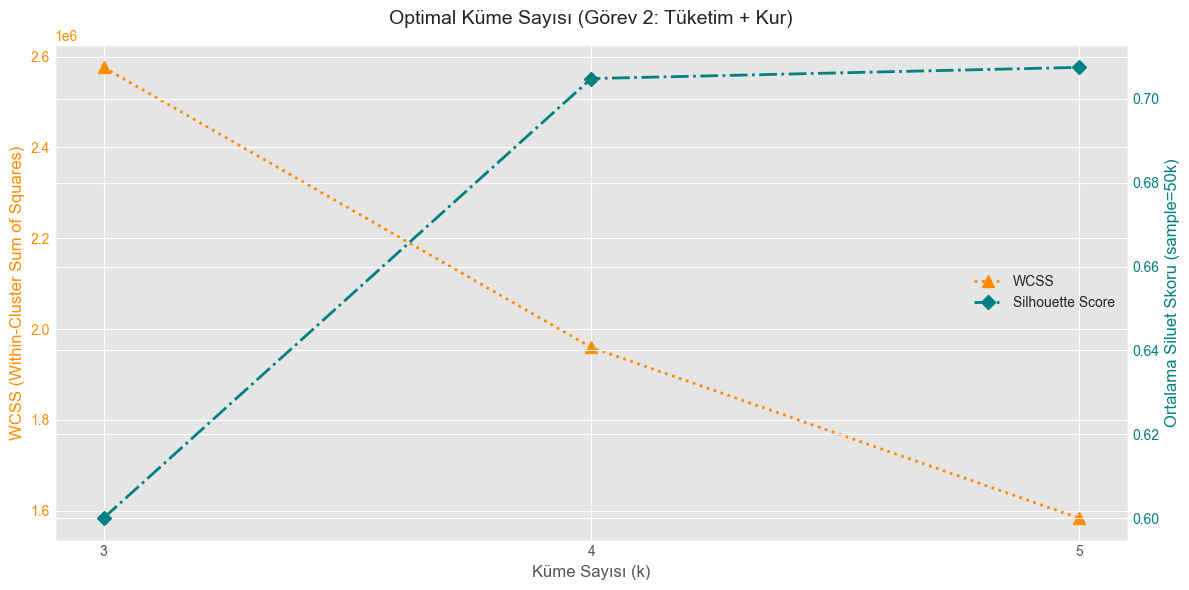


En Yüksek Ortalama Siluet Skoru (Görev 2): 0.7075 (k=5)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from IPython.display import display

if 'X_task2_scaled' not in locals():
    print("UYARI: 'X_task2_scaled' bulunamadı. Rastgele örnek veri kullanılıyor (15 özellik)...")
    n_samples_task2 = 80000 
    n_features_task2 = 15 
    np.random.seed(13) 
    X_task2_raw = np.random.rand(n_samples_task2, n_features_task2)
    scaler_task2_example = StandardScaler()
    X_task2_scaled = scaler_task2_example.fit_transform(X_task2_raw)
    print(f"Örnek veri (X_task2_scaled) boyutu: {X_task2_scaled.shape}")


wcss_task2 = []
silhouette_scores_task2 = []
k_range_task2 = range(3, 6) 


start_time_task2 = time.time()

print(f"\nOptimal küme sayısı belirleniyor (Görev 2: Tüketim + Kur)")
print(f"k={k_range_task2.start} ile {k_range_task2.stop-1} arası deneniyor...")
print(f"Silhouette Score hesaplamasında sample_size=50000 kullanılacak.")
if X_task2_scaled.shape[0] < 2:
     print("UYARI: Görev 2 için kümeleme yapılamıyor (veri noktası sayısı < 2). Adım atlanıyor.")
else:
    for k in k_range_task2:
       
        if k >= X_task2_scaled.shape[0]:
            print(f"k={k} atlanıyor: Küme sayısı ({k}), veri noktası sayısından ({X_task2_scaled.shape[0]}) fazla veya eşit olamaz.")
            
            wcss_task2.append(np.nan) 
            silhouette_scores_task2.append(np.nan)
            continue 

        k_start_time = time.time()
        kmeans_model_task2 = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=13, max_iter=300)
        
        cluster_labels_task2_temp = kmeans_model_task2.fit_predict(X_task2_scaled)

       
        wcss_task2.append(kmeans_model_task2.inertia_)

       
        sil_start_time = time.time()
        score_task2 = np.nan 
        
        unique_labels = np.unique(cluster_labels_task2_temp)
        if 1 < len(unique_labels) < X_task2_scaled.shape[0]:
             try:
                  score_task2 = silhouette_score(X_task2_scaled, cluster_labels_task2_temp, metric='euclidean',
                                            sample_size=50000, random_state=13)
             except Exception as e:
                  print(f"k={k} için Siluet Skoru hesaplanırken hata oluştu: {e}. NaN olarak işaretleniyor.")
                  score_task2 = np.nan
        else:
             print(f"k={k} için Siluet Skoru hesaplanamıyor (geçersiz küme sayısı veya tek küme oluştu: {len(unique_labels)}). NaN olarak işaretleniyor.")
             score_task2 = np.nan
        sil_end_time = time.time()
        silhouette_scores_task2.append(score_task2)

        k_end_time = time.time()
        wcss_str = f"{wcss_task2[-1]:.2f}" if not np.isnan(wcss_task2[-1]) else "Hesaplanamadı"
        score_str = f"{score_task2:.4f}" if not np.isnan(score_task2) else "Hesaplanamadı"
        print(f"k={k}: WCSS = {wcss_str}, Silhouette Score = {score_str} "
              f"(Hesaplama süresi: {k_end_time - k_start_time:.2f} s, "
              f"Silhouette süresi: {sil_end_time - sil_start_time:.2f} s)")

    print("\nHesaplamalar tamamlandı (Görev 2).")
    total_time_task2 = time.time() - start_time_task2
    print(f"Toplam hesaplama süresi (Görev 2): {total_time_task2:.2f} saniye.")


plt.style.use('ggplot') 
valid_indices = [i for i, w in enumerate(wcss_task2) if not np.isnan(w)]
valid_k = [k_range_task2[i] for i in valid_indices]
valid_wcss = [wcss_task2[i] for i in valid_indices]
valid_sil_indices = [i for i, s in enumerate(silhouette_scores_task2) if not np.isnan(s)]
valid_sil_k = [k_range_task2[i] for i in valid_sil_indices]
valid_sil_scores = [silhouette_scores_task2[i] for i in valid_sil_indices]


if not valid_k:
    print("\nGrafik çizilemiyor: Görev 2 için geçerli WCSS verisi yok.")
else:
    fig2, ax1_task2 = plt.subplots(figsize=(12, 6))

    
    color_wcss = 'darkorange' 
    ax1_task2.set_xlabel('Küme Sayısı (k)', fontsize=12)
    ax1_task2.set_ylabel('WCSS (Within-Cluster Sum of Squares)', color=color_wcss, fontsize=12)
    ax1_task2.plot(valid_k, valid_wcss, marker='^', linestyle=':', color=color_wcss, label='WCSS', markersize=8, linewidth=2) 
    ax1_task2.tick_params(axis='y', labelcolor=color_wcss, labelsize=10)
    ax1_task2.tick_params(axis='x', labelsize=10)
    ax1_task2.set_title('Optimal Küme Sayısı (Görev 2: Tüketim + Kur)', fontsize=14, pad=15)
    

    
    ax2_task2 = ax1_task2.twinx() 
    color_sil = 'teal' 
    ax2_task2.set_ylabel('Ortalama Siluet Skoru (sample=50k)', color=color_sil, fontsize=12) 
    if valid_sil_k: 
        ax2_task2.plot(valid_sil_k, valid_sil_scores, marker='D', linestyle='-.', color=color_sil, label='Silhouette Score', markersize=7, linewidth=2)
    ax2_task2.tick_params(axis='y', labelcolor=color_sil, labelsize=10)

    
    lines, labels = ax1_task2.get_legend_handles_labels()
    lines2, labels2 = ax2_task2.get_legend_handles_labels()
    ax2_task2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=10) 

    fig2.tight_layout() 
    plt.xticks(list(k_range_task2)) 
    plt.show()


if valid_sil_scores:
    best_silhouette_score_task2 = max(valid_sil_scores)
    best_score_index = silhouette_scores_task2.index(best_silhouette_score_task2)
    optimal_k_task2_silhouette = k_range_task2[best_score_index]
    print(f"\nEn Yüksek Ortalama Siluet Skoru (Görev 2): {best_silhouette_score_task2:.4f} (k={optimal_k_task2_silhouette})")
else:
    print("\nGeçerli Siluet Skoru hesaplanamadı (Görev 2).")
    optimal_k_task2_silhouette = None 



Silüet skoru hesapladım tekrardan. 50000 sample size kullandım uzun sürmemesi için  Elbowla da gösterim yaptım.


Veri noktalarına küme etiketleri (5 küme) 'cluster_kur_etkisi' sütununa atandı.

Her kümedeki eleman sayısı (Görev 2):
cluster_kur_etkisi
0    94237
1    63408
2    57096
3       69
4     1061
Name: count, dtype: int64

--- Küme Merkezleri (Orijinal Ölçek - Görev 2) ---


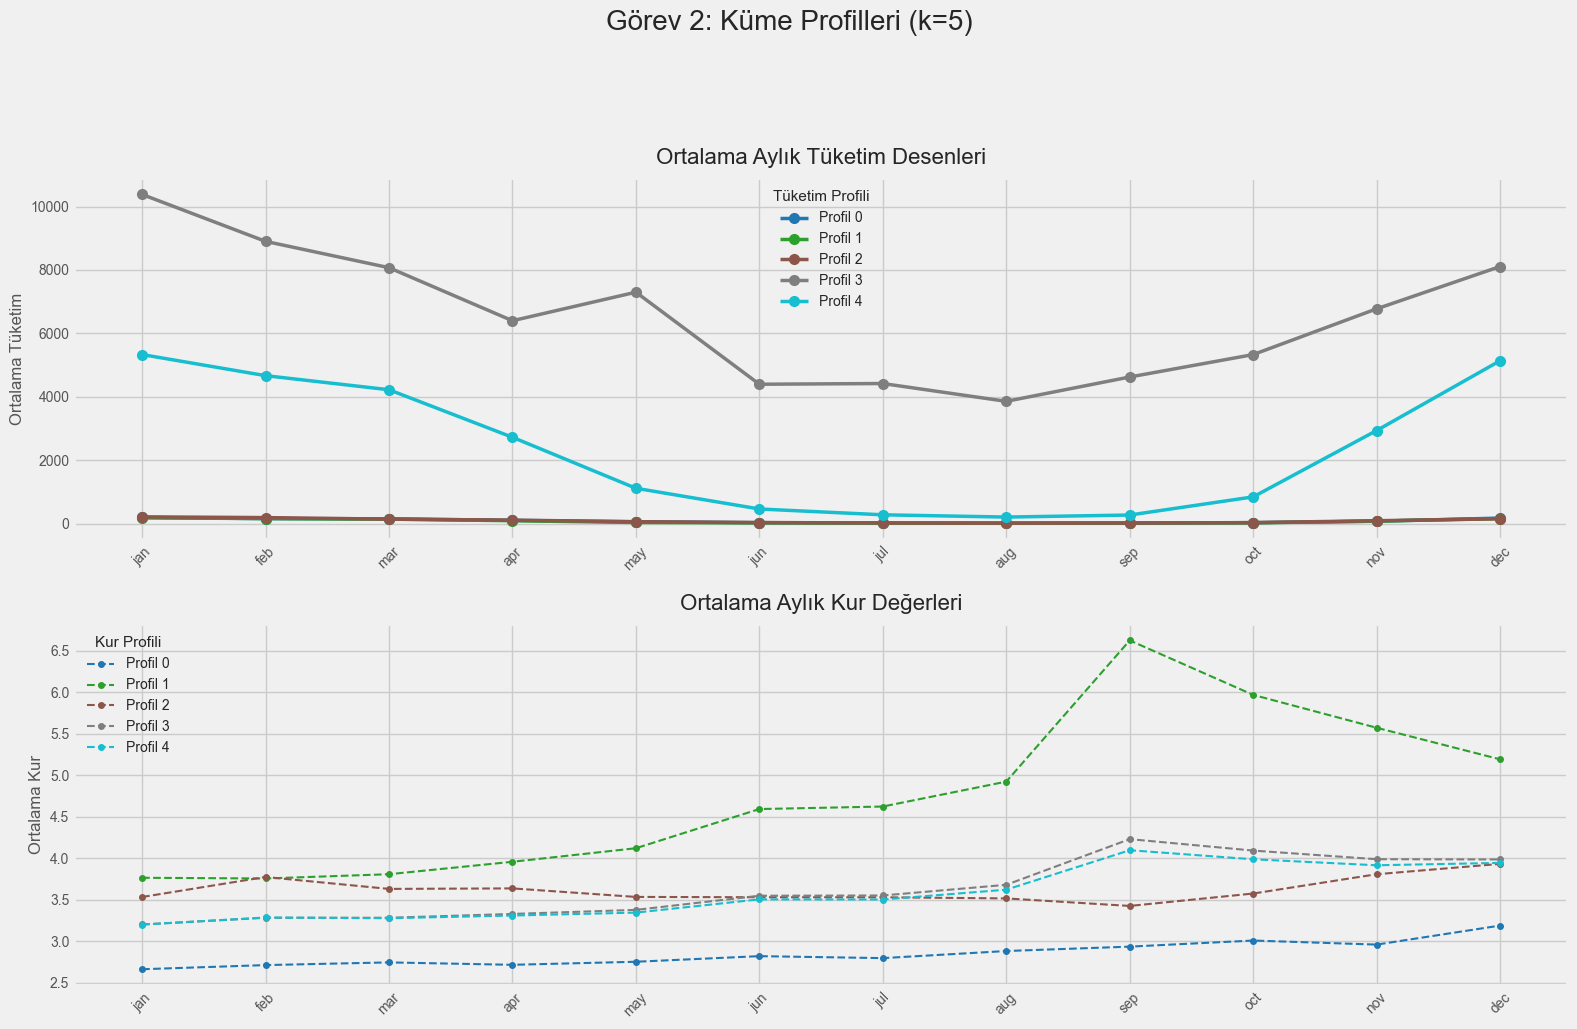

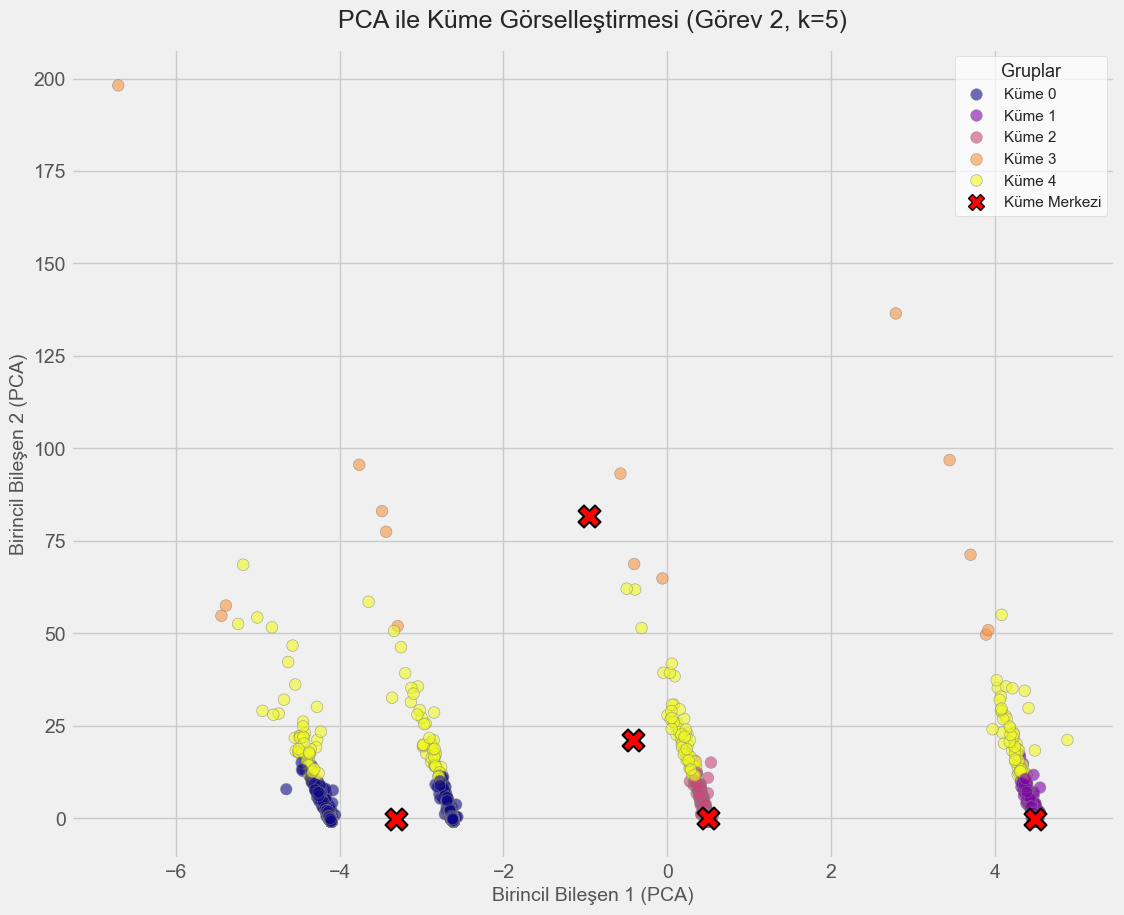

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display

optimal_k_task2 = 5
kmeans_final_task2 = KMeans(n_clusters=optimal_k_task2, init='k-means++', n_init=10, random_state=13, max_iter=300)
cluster_labels_task2 = kmeans_final_task2.fit_predict(X_task2_scaled)
if len(df_processed) == len(cluster_labels_task2):
    df_processed['cluster_kur_etkisi'] = cluster_labels_task2
    print(f"\nVeri noktalarına küme etiketleri ({optimal_k_task2} küme) 'cluster_kur_etkisi' sütununa atandı.")
    print("\nHer kümedeki eleman sayısı (Görev 2):")
    print(df_processed['cluster_kur_etkisi'].value_counts().sort_index())
else:
    print(f"\nUYARI: df_processed satır sayısı ({len(df_processed)}) ile küme etiket sayısı ({len(cluster_labels_task2)}) eşleşmiyor!")
    print("Küme etiketleri df_processed'e eklenemedi. Lütfen index eşleşmesini kontrol edin.")
    




cluster_centers_original_task2 = scaler_task2.inverse_transform(kmeans_final_task2.cluster_centers_)


try:
    center_cols_task2 = df_task2_data.columns.tolist()
except AttributeError:
    print("UYARI: 'df_task2_data' DataFrame değil veya sütunları alınamıyor. Sütun isimleri varsayılan olarak atanacak.")
    center_cols_task2 = [f'Feature_{i+1}' for i in range(X_task2_scaled.shape[1])]

df_cluster_centers_original_task2 = pd.DataFrame(cluster_centers_original_task2, columns=center_cols_task2)
df_cluster_centers_original_task2.index.name = 'Küme_ID'

print("\n--- Küme Merkezleri (Orijinal Ölçek - Görev 2) ---")
tuketim_center_cols = [col for col in center_cols_task2 if 'tuketim' in col.lower()]
kur_center_cols = [col for col in center_cols_task2 if 'kur' in col.lower()]       

if not tuketim_center_cols: print("UYARI: Tüketim sütunları ('tuketim' içeren) bulunamadı.")
if not kur_center_cols: print("UYARI: Kur sütunları ('kur' içeren) bulunamadı.")


plt.style.use('fivethirtyeight') 

fig_task2, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=False) 
fig_task2.suptitle(f'Görev 2: Küme Profilleri (k={optimal_k_task2})', fontsize=20, y=1.03) 

palette = plt.cm.get_cmap('tab10', optimal_k_task2) 

def clean_axis_labels(cols):
    try:
       
        return [col.split('_')[1] + " " + col.split('_')[2] if len(col.split('_')) > 2 else col.split('_')[0]
                for col in cols]
    except:
        
        return cols


ax = axes[0]
if tuketim_center_cols: 
    x_labels_tuketim = clean_axis_labels(tuketim_center_cols)
    for i in range(optimal_k_task2):
        ax.plot(x_labels_tuketim,
                df_cluster_centers_original_task2.loc[i, tuketim_center_cols],
                marker='o', 
                markersize=7,
                linestyle='-',
                linewidth=2.5, 
                color=palette(i),
                label=f'Profil {i}') 
    ax.set_title('Ortalama Aylık Tüketim Desenleri', fontsize=16, pad=10)
    ax.set_ylabel('Ortalama Tüketim', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(title="Tüketim Profili", fontsize=10, title_fontsize=11)
    
else:
     ax.text(0.5, 0.5, 'Tüketim verisi çizilemedi.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14, color='red')
     ax.set_title('Ortalama Aylık Tüketim Desenleri', fontsize=16, pad=10)



ax = axes[1]
if kur_center_cols: 
    x_labels_kur = clean_axis_labels(kur_center_cols)
    for i in range(optimal_k_task2):
        ax.plot(x_labels_kur,
                df_cluster_centers_original_task2.loc[i, kur_center_cols],
                marker='.', 
                markersize=8,
                linestyle='--',
                linewidth=1.5, 
                color=palette(i), 
                label=f'Profil {i}')
    ax.set_title('Ortalama Aylık Kur Değerleri', fontsize=16, pad=10)
    ax.set_ylabel('Ortalama Kur', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(title="Kur Profili", fontsize=10, title_fontsize=11)
   
else:
     ax.text(0.5, 0.5, 'Kur verisi çizilemedi.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=14, color='red')
     ax.set_title('Ortalama Aylık Kur Değerleri', fontsize=16, pad=10)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()
if 'pca1_task2' not in df_processed.columns:
    print("\nPCA hesaplanıyor (Görev 2)...")
    pca_task2 = PCA(n_components=2, random_state=13) 
    X_task2_pca = pca_task2.fit_transform(X_task2_scaled)
    if len(df_processed) == len(X_task2_pca):
        df_processed['pca1_task2'] = X_task2_pca[:, 0]
        df_processed['pca2_task2'] = X_task2_pca[:, 1]
        print("PCA bileşenleri 'pca1_task2', 'pca2_task2' olarak df_processed'e eklendi.")
    
    else:
        print("UYARI: df_processed satır sayısı PCA sonuçları ile eşleşmiyor. PCA görselleştirmesi yapılamayabilir.")
       
        pca_task2 = None 



if 'pca1_task2' in df_processed.columns and 'cluster_kur_etkisi' in df_processed.columns and pca_task2 is not None:
    plt.figure(figsize=(12, 10)) 

    
    scatter_plot = sns.scatterplot(
        data=df_processed.sample(min(len(df_processed), 50000), random_state=13), 
        x='pca1_task2',
        y='pca2_task2',
        hue='cluster_kur_etkisi', 
        palette='plasma',      
        s=70,                   
        alpha=0.6,             
        edgecolor='grey',       
        linewidth=0.5
    )

   
    if kmeans_final_task2 is not None:
        pca_centers_task2 = pca_task2.transform(kmeans_final_task2.cluster_centers_)
        plt.scatter(pca_centers_task2[:, 0], pca_centers_task2[:, 1],
                    marker='X',          
                    s=250,              
                    c='red',            
                    edgecolor='black',   
                    linewidth=1.5,
                    label='Küme Merkezi') 

    plt.title(f'PCA ile Küme Görselleştirmesi (Görev 2, k={optimal_k_task2})', fontsize=18, pad=15)
    plt.xlabel('Birincil Bileşen 1 (PCA)', fontsize=14)
    plt.ylabel('Birincil Bileşen 2 (PCA)', fontsize=14)

   
    handles, labels = scatter_plot.get_legend_handles_labels()
    
    if kmeans_final_task2 is not None:
        
         center_handle = plt.Line2D([0], [0], marker='X', color='w', label='Küme Merkezi',
                                   markerfacecolor='red', markeredgecolor='black', markersize=12, linestyle='')
         
         new_labels = [f'Küme {l}' for l in labels[:-1]] + ['Küme Merkezi'] 
         new_handles = handles[:-1] + [center_handle]
         plt.legend(handles=new_handles, labels=new_labels, title='Gruplar', title_fontsize='13', fontsize='11', loc='best', frameon=True, facecolor='white', framealpha=0.7)
    else:
         plt.legend(title='Küme', title_fontsize='13', fontsize='11', loc='best')


    
    plt.show()
else:
    print("\nPCA görselleştirmesi için gerekli sütunlar ('pca1_task2', 'pca2_task2', 'cluster_kur_etkisi') df_processed içinde bulunamadı veya PCA hesaplanamadı.")




Kümeler ve ortalama tüketimlerle ilgili PCA grafiği ve diğer grafikleri çizdim.


--- Görselleştirme 1: Küme Tüketim Profili Heatmap ---


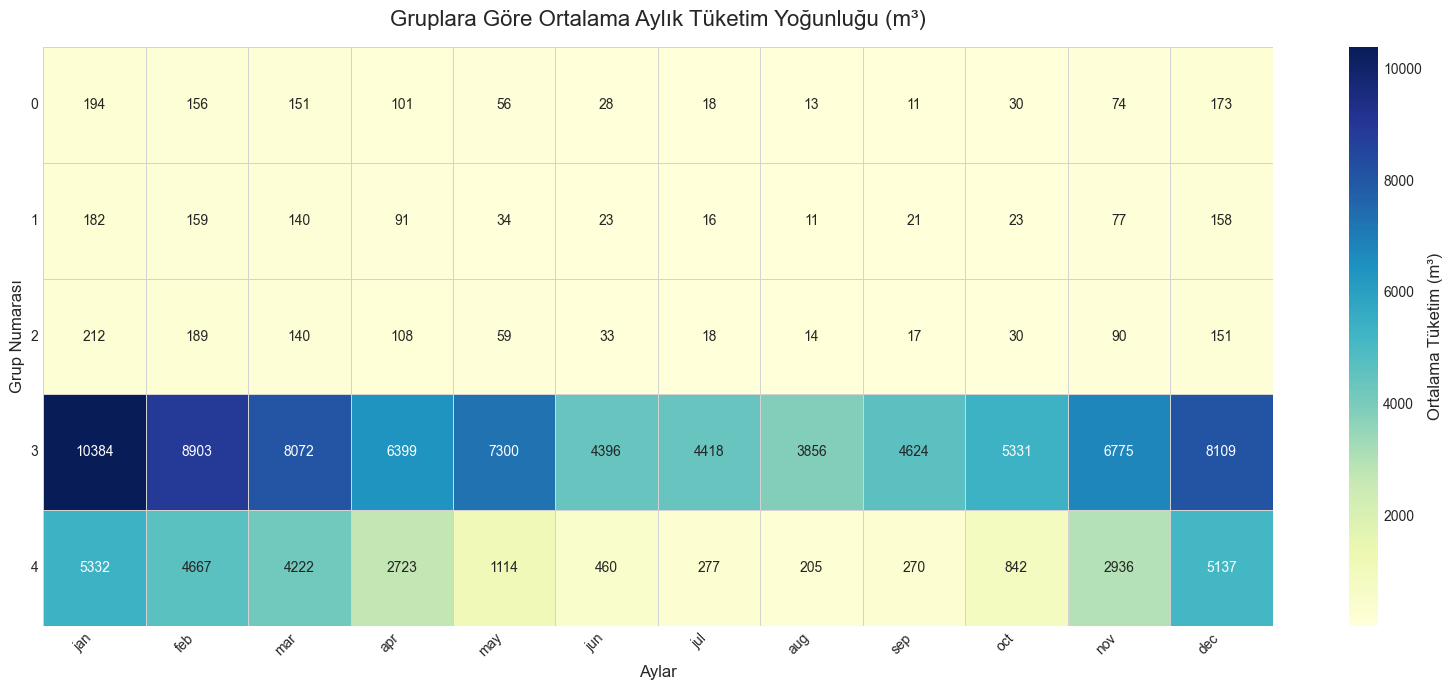

2018 yılına ait 63726 kayıt bulundu.
UYARI: Şu kümeler incelenecek: [3, 4]. (Diğerleri 2018'de bulunamadı)
Kur zirve dönemi vurgulandı (Ağu-Eki).


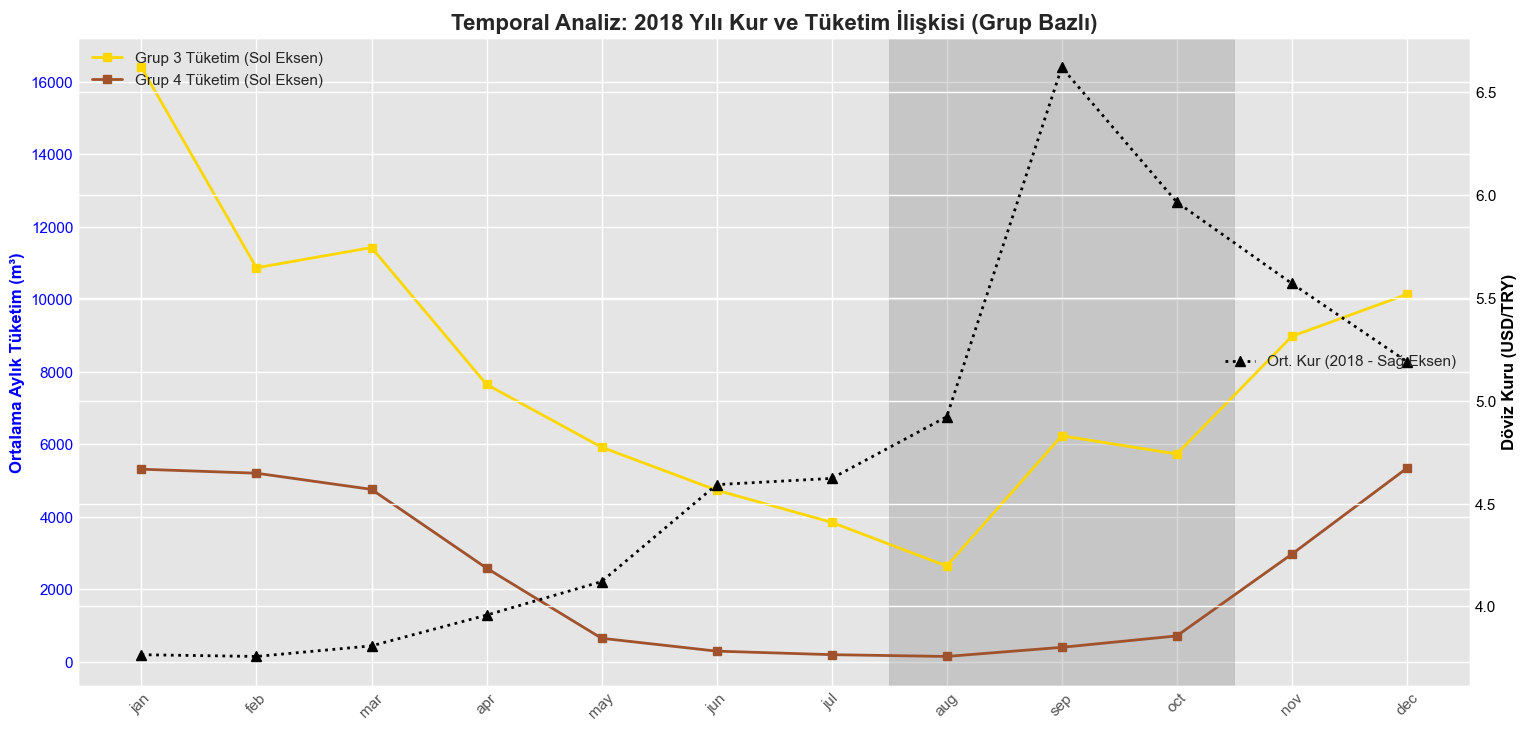


--- Görselleştirme 3: 2018  Sonrası Tüketim Değişim Yüzdesi ---
Grup 3 - 2018 Şok Sonrası Tüketim Değişimi: -22.4%
Grup 4 - 2018 Şok Sonrası Tüketim Değişimi: -29.4%


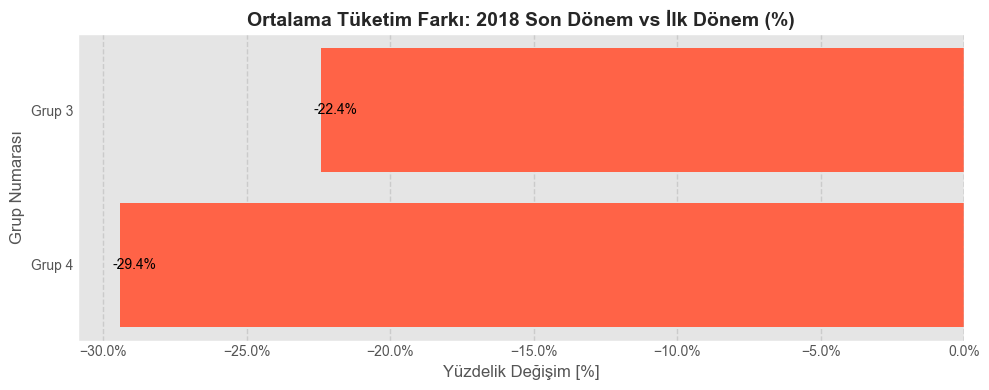

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import seaborn as sns


required_vars = [
    'df_cluster_centers_original_task2', 
    'tuketim_center_cols',           
    'df_processed',                  
    'aylik_tuketim_sutunlari',       
    'aylik_kur_sutunlari'            
]


proceed = True


if proceed:
    print("\n--- Görselleştirme 1: Küme Tüketim Profili Heatmap ---")
    try:
        
        heatmap_data = df_cluster_centers_original_task2[tuketim_center_cols]

        
        heatmap_data.columns = [col.replace('_tuketim', '') for col in tuketim_center_cols]

        plt.style.use('seaborn-v0_8-whitegrid') 
        plt.figure(figsize=(16, 7)) 

        sns.heatmap(
            heatmap_data,
            annot=True,         
            fmt=".0f",           
            cmap='YlGnBu',      
            linewidths=0.5,      
            linecolor='lightgrey',
            cbar_kws={'label': 'Ortalama Tüketim (m³)'}, 
            annot_kws={"size": 10} 
        )

        plt.title('Gruplara Göre Ortalama Aylık Tüketim Yoğunluğu (m³)', fontsize=16, pad=15)
        plt.xlabel('Aylar', fontsize=12)
        plt.ylabel('Grup Numarası', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10) 
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Heatmap oluşturulurken bir hata oluştu: {e}")



if proceed:
    

  
    df_2018 = df_processed[df_processed['year'] == 2018].copy()

    if df_2018.empty:
        print("UYARI: 2018 yılına ait veri bulunamadı. Zaman serisi analizi yapılamıyor.")
    elif 'cluster_kur_etkisi' not in df_2018.columns:
         print("UYARI: 2018 verisinde 'cluster_kur_etkisi' sütunu bulunamadı.")
    else:
        print(f"2018 yılına ait {len(df_2018)} kayıt bulundu.")

        
        clusters_to_plot_ts = [0, 3, 4] 

        
        try:
            
            avg_tuketim_2018_all = df_2018.groupby('cluster_kur_etkisi')[aylik_tuketim_sutunlari].mean()
          
            valid_clusters_ts = [c for c in clusters_to_plot_ts if c in avg_tuketim_2018_all.index]
            if not valid_clusters_ts:
                 print(f"UYARI: İncelenmek istenen kümelerden ({clusters_to_plot_ts}) hiçbiri 2018 verisinde bulunamadı.")
                 raise ValueError("Analiz için geçerli küme yok.") 
            elif len(valid_clusters_ts) < len(clusters_to_plot_ts):
                 print(f"UYARI: Şu kümeler incelenecek: {valid_clusters_ts}. (Diğerleri 2018'de bulunamadı)")

            avg_tuketim_2018_filtered = avg_tuketim_2018_all.loc[valid_clusters_ts]

        except KeyError:
             print(f"HATA: İncelenmek istenen kümelerden bazıları ({clusters_to_plot_ts}) 2018 verisinde bulunamadı.")
             proceed_ts = False 
        except ValueError as ve:
             print(ve)
             proceed_ts = False
        except Exception as e:
             print(f"2018 ortalama tüketim hesaplanırken hata: {e}")
             proceed_ts = False
        else:
             proceed_ts = True 

        if proceed_ts:
            
            avg_kur_2018 = df_2018[aylik_kur_sutunlari].mean()

           
            plt.style.use('ggplot') 

            fig_ts, ax_ts1 = plt.subplots(figsize=(16, 8))
            ax_ts2 = ax_ts1.twinx() 

            
            ts_colors = {
                0: '#87CEEB', 
                3: '#FFD700',  
                4: '#A0522D'  
            }
            default_color = '#777777'

           
            x_labels_ts = [col.replace('_tuketim', '') for col in aylik_tuketim_sutunlari]
            x_labels_kur_ts = [col.replace('_kur', '') for col in aylik_kur_sutunlari]


           
            for cluster_id in valid_clusters_ts:
                ax_ts1.plot(x_labels_ts, avg_tuketim_2018_filtered.loc[cluster_id].values,
                            color=ts_colors.get(cluster_id, default_color),
                            marker='s', 
                            markersize=6,
                            linewidth=2,
                            label=f'Grup {cluster_id} Tüketim (Sol Eksen)')

            ax_ts1.set_ylabel('Ortalama Aylık Tüketim (m³)', color='blue', fontsize=12, fontweight='bold')
            ax_ts1.tick_params(axis='y', labelcolor='blue', labelsize=11)
            ax_ts1.tick_params(axis='x', rotation=45, labelsize=11)
            ax_ts1.legend(loc='upper left', fontsize=11)
            
            ax_ts2.plot(x_labels_kur_ts, avg_kur_2018.values,
                        color='black',            
                        linestyle=':',           
                        linewidth=2,
                        marker='^',              
                        markersize=7,
                        label='Ort. Kur (2018 - Sağ Eksen)')
            ax_ts2.set_ylabel('Döviz Kuru (USD/TRY)', color='black', fontsize=12, fontweight='bold')
            ax_ts2.tick_params(axis='y', labelcolor='black', labelsize=11)
            ax_ts2.legend(loc='center right', fontsize=11) 

            
            try:
                start_idx = x_labels_kur_ts.index('aug')
                end_idx = x_labels_kur_ts.index('oct')
               
                ax_ts1.axvspan(start_idx -0.5, end_idx + 0.5 , color='grey', alpha=0.3, label='Kur Zirve Dönemi (Ağu-Eki)') 
                print("Kur zirve dönemi vurgulandı (Ağu-Eki).")
            except ValueError:
                print("UYARI: Kur zirve dönemi etiketleri ('aug', 'oct') x ekseninde bulunamadı. Vurgulama yapılamadı.")


            plt.title('Temporal Analiz: 2018 Yılı Kur ve Tüketim İlişkisi (Grup Bazlı)', fontsize=16, fontweight='bold')
            
            plt.show()


if proceed and proceed_ts: 
    print("\n--- Görselleştirme 3: 2018  Sonrası Tüketim Değişim Yüzdesi ---")

    
    cols_pre_shock = [col for col in aylik_tuketim_sutunlari if col.split('_')[0] in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul']]
    cols_post_shock = [col for col in aylik_tuketim_sutunlari if col.split('_')[0] in ['aug', 'sep', 'oct', 'nov', 'dec']]

    
    if not all(col in avg_tuketim_2018_filtered.columns for col in cols_pre_shock + cols_post_shock):
        print("UYARI: Şok öncesi veya sonrası dönem için bazı tüketim sütunları eksik. Değişim hesaplanamıyor.")
    else:
        consumption_change = {}
        for cluster_id in valid_clusters_ts: 
            pre_shock_avg = avg_tuketim_2018_filtered.loc[cluster_id, cols_pre_shock].mean()
            post_shock_avg = avg_tuketim_2018_filtered.loc[cluster_id, cols_post_shock].mean()
            
            if pre_shock_avg is not None and pre_shock_avg != 0:
                change_pct = ((post_shock_avg - pre_shock_avg) / pre_shock_avg) * 100
            else:
                change_pct = 0 
            consumption_change[f'Grup {cluster_id}'] = change_pct
            print(f"Grup {cluster_id} - 2018 Şok Sonrası Tüketim Değişimi: {change_pct:.1f}%")

        if consumption_change:
            
            consumption_series = pd.Series(consumption_change).sort_values()

            plt.style.use('ggplot')  
            fig_bar, ax_bar = plt.subplots(figsize=(10, max(4, len(consumption_series) * 1.2)))

           
            bars = ax_bar.barh(consumption_series.index, consumption_series.values,
                             color='#FF6347') 

           
            for bar in bars:
                width = bar.get_width()
                
                x_pos = width + (1 if width >= 0 else -1) * np.sign(width) * 0.5 
                y_pos = bar.get_y() + bar.get_height() / 2
                ax_bar.text(x_pos, y_pos, f'{width:.1f}%', 
                            va='center', ha='center', color='black', fontsize=10)

            ax_bar.set_title('Ortalama Tüketim Farkı: 2018 Son Dönem vs İlk Dönem (%)', fontsize=14, fontweight='bold')
            ax_bar.set_xlabel('Yüzdelik Değişim [%]', fontsize=12)
            ax_bar.set_ylabel('Grup Numarası', fontsize=12)
            ax_bar.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100)) 
            ax_bar.axvline(0, color='grey', lw=1, linestyle='--') 
            
            ax_bar.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
            ax_bar.yaxis.grid(False) 

            plt.tight_layout()
            plt.show()
        else:
            print("Yüzdelik değişim verisi hesaplanamadı veya boş.")


Ortalama kur ve kur şokuna göre değişim grafiklerini çizdirdim. 

Gerekli DataFrame (df_processed) ve ölçeklenmiş veri (X_task2_scaled) bulundu.

Anomali Analizi Görselleştirmeleri Oluşturuluyor...


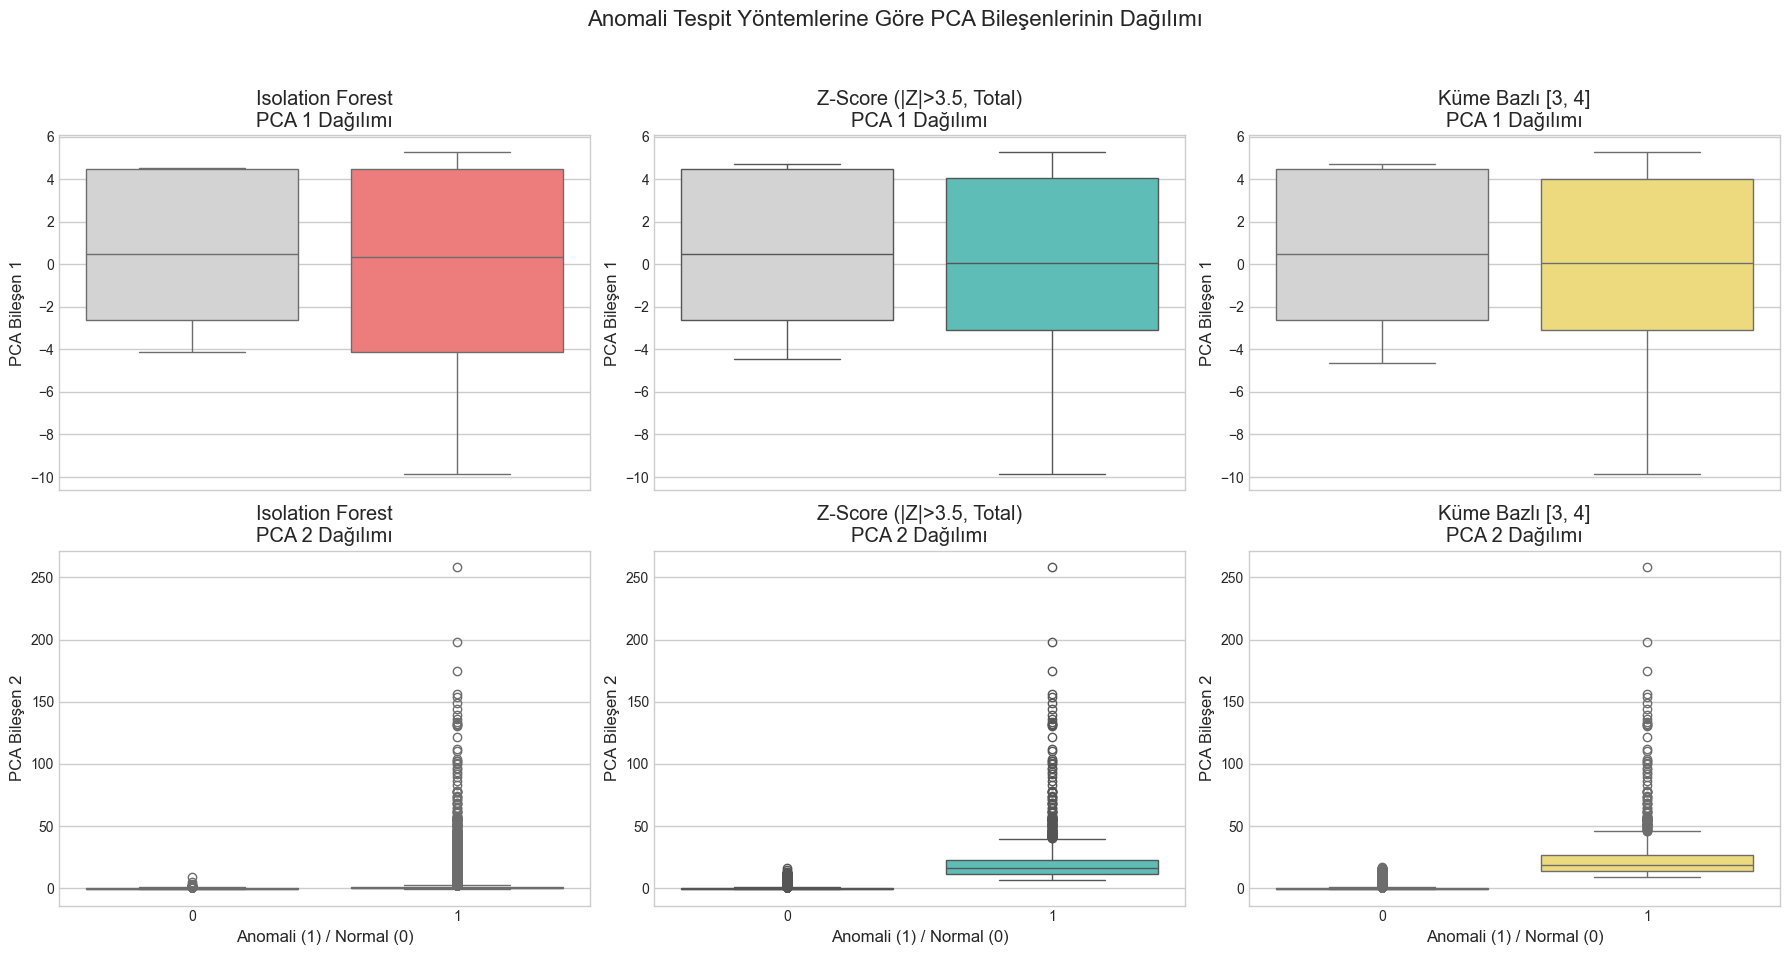

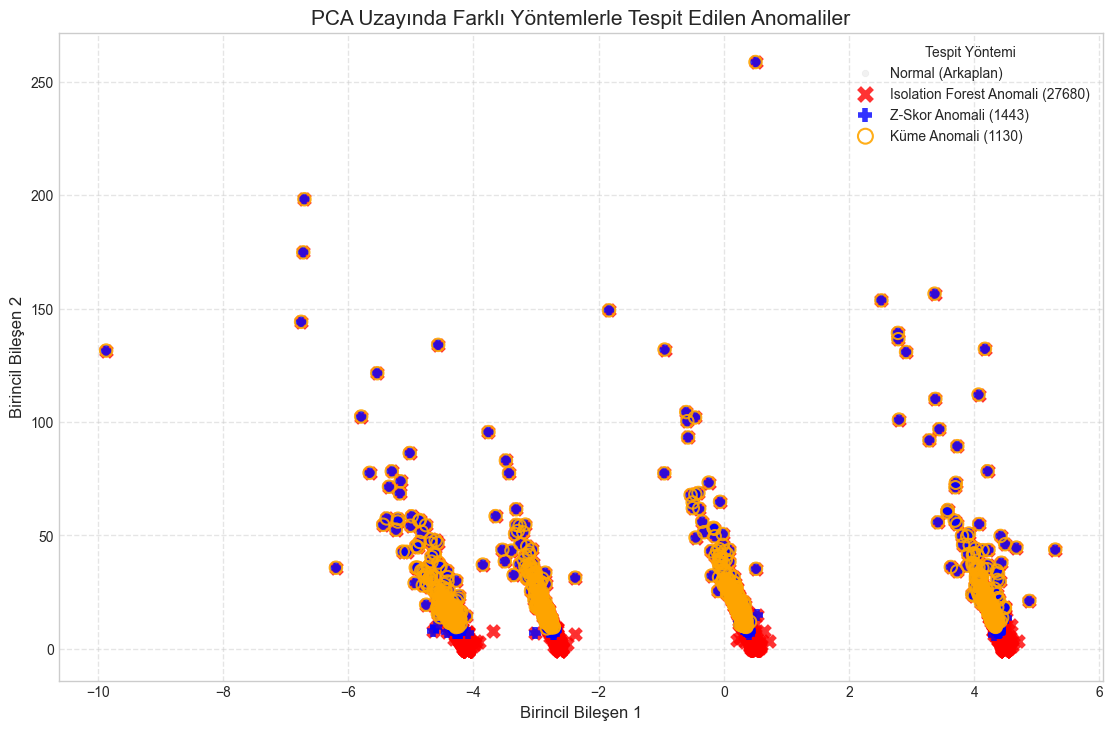


Toplam Tüketime Göre Z-Skoru En Yüksek 5 Profil:


,year,jan_kur,feb_kur,mar_kur,apr_kur,may_kur,jun_kur,jul_kur,aug_kur,sep_kur,...,nov_tuketim,dec_tuketim,total_tuketim,cluster_kur_etkisi,pca1_task2,pca2_task2,anomaly_if,total_tuketim_zscore,anomaly_zscore,anomaly_cluster_task2
215870,2018,3.7652,3.7567,3.8082,3.9577,4.1208,4.5922,4.6225,4.9223,6.6213,...,39532.73,28820.820000,315300.260000,3,0.505962,258.583461,1,108.118811,1,1
215869,2015,2.3449,2.4236,2.5187,2.6008,2.7109,2.6762,2.6992,2.7736,2.9147,...,21747.80,23522.030000,230985.860000,3,-6.699445,198.140977,1,79.100190,1,1
215868,2015,2.3449,2.4236,2.5187,2.6008,2.7109,2.6762,2.6992,2.7736,2.9147,...,7972.34,24342.690000,210617.230000,3,-6.751726,144.134866,1,72.089886,1,1
215867,2018,3.7652,3.7567,3.8082,3.9577,4.1208,4.5922,4.6225,4.9223,6.6213,...,24644.98,24876.200000,202992.700000,3,2.780581,139.252406,1,69.465739,1,1
215866,2015,2.3449,2.4236,2.5187,2.6008,2.7109,2.6762,2.6992,2.7736,2.9147,...,0.00,17391.627691,196511.741328,3,-9.866327,131.463364,1,67.235177,1,1



Anomali analizi tamamlandı.


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
try:
    _ = df_processed
    _ = X_task2_scaled
    required_cols = ['pca1_task2', 'pca2_task2', 'total_tuketim', 'cluster_kur_etkisi']
    if not all(col in df_processed.columns for col in required_cols):
        raise NameError(f"df_processed DataFrame'inde gerekli sütunlar eksik: {required_cols}")
    print("Gerekli DataFrame (df_processed) ve ölçeklenmiş veri (X_task2_scaled) bulundu.")
except NameError as e:
     print(f"Hata: Gerekli değişkenler tanımlı değil veya df_processed'da sütunlar eksik! ({e})")
     print("Lütfen önce veri hazırlama ve kümeleme adımlarını çalıştırdığınızdan emin olun.")
     print("Uyarı: Gerçek veri yerine örnek bir df_processed oluşturuluyor.")
     from sklearn.datasets import make_blobs
     X_task2_scaled, _ = make_blobs(n_samples=2000, centers=5, n_features=10, random_state=13)
     pca_temp = PCA(n_components=2, random_state=13)
     pca_result_temp = pca_temp.fit_transform(X_task2_scaled)
     kmeans_temp = KMeans(n_clusters=5, random_state=13, n_init=10)
     clusters_temp = kmeans_temp.fit_predict(X_task2_scaled)
     df_processed = pd.DataFrame({
         'pca1_task2': pca_result_temp[:, 0],
         'pca2_task2': pca_result_temp[:, 1],
         'total_tuketim': np.random.rand(2000) * 1000 + X_task2_scaled[:, 0] * 50,
         'cluster_kur_etkisi': clusters_temp
     })
     num_outliers = 20
     outlier_indices = np.random.choice(df_processed.index, num_outliers, replace=False)
     df_processed.loc[outlier_indices, 'total_tuketim'] *= np.random.uniform(5, 15, num_outliers)
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=13, n_jobs=-1)
anomaly_labels_if = iso_forest.fit_predict(X_task2_scaled)
df_processed['anomaly_if'] = np.where(anomaly_labels_if == -1, 1, 0) 
df_processed['total_tuketim_zscore'] = zscore(df_processed['total_tuketim'])
z_threshold = 3.5
df_processed['anomaly_zscore'] = (np.abs(df_processed['total_tuketim_zscore']) > z_threshold).astype(int)
anomalous_clusters = [3, 4]
df_processed['anomaly_cluster_task2'] = df_processed['cluster_kur_etkisi'].apply(lambda x: 1 if x in anomalous_clusters else 0)
print("\nAnomali Analizi Görselleştirmeleri Oluşturuluyor...")
fig_dist, axes_dist = plt.subplots(2, 3, figsize=(18, 10), sharex='col')
anomaly_methods = ['anomaly_if', 'anomaly_zscore', 'anomaly_cluster_task2']
titles = ['Isolation Forest', f'Z-Score (|Z|>{z_threshold}, Total)', f'Küme Bazlı {anomalous_clusters}']
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']
for i, method in enumerate(anomaly_methods):
    
    current_palette = {'0': 'lightgray', '1': colors[i]}

   
    sns.boxplot(data=df_processed, x=method, y='pca1_task2', ax=axes_dist[0, i], palette=current_palette)
    axes_dist[0, i].set_title(f'{titles[i]}\nPCA 1 Dağılımı')
    axes_dist[0, i].set_xlabel('Anomali (1) / Normal (0)')
    axes_dist[0, i].set_ylabel('PCA Bileşen 1')

   
    sns.boxplot(data=df_processed, x=method, y='pca2_task2', ax=axes_dist[1, i], palette=current_palette) 
    axes_dist[1, i].set_title(f'{titles[i]}\nPCA 2 Dağılımı')
    axes_dist[1, i].set_xlabel('Anomali (1) / Normal (0)')
    axes_dist[1, i].set_ylabel('PCA Bileşen 2')

plt.suptitle('Anomali Tespit Yöntemlerine Göre PCA Bileşenlerinin Dağılımı', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



plt.figure(figsize=(12, 8))

plt.scatter(df_processed['pca1_task2'], df_processed['pca2_task2'],
            c='lightgrey', alpha=0.3, s=15, label='Normal (Arkaplan)')

if_anomalies = df_processed[df_processed['anomaly_if'] == 1]
plt.scatter(if_anomalies['pca1_task2'], if_anomalies['pca2_task2'],
            c='red', marker='x', s=60, label=f'Isolation Forest Anomali ({len(if_anomalies)})', alpha=0.8)

z_anomalies = df_processed[df_processed['anomaly_zscore'] == 1]
plt.scatter(z_anomalies['pca1_task2'], z_anomalies['pca2_task2'],
            c='blue', marker='+', s=70, label=f'Z-Skor Anomali ({len(z_anomalies)})', alpha=0.8)

cluster_anomalies = df_processed[df_processed['anomaly_cluster_task2'] == 1]
plt.scatter(cluster_anomalies['pca1_task2'], cluster_anomalies['pca2_task2'],
             facecolors='none', edgecolors='orange',
             marker='o', s=80, label=f'Küme Anomali ({len(cluster_anomalies)})', alpha=0.9, linewidths=1.5)

plt.title('PCA Uzayında Farklı Yöntemlerle Tespit Edilen Anomaliler', fontsize=15)
plt.xlabel('Birincil Bileşen 1')
plt.ylabel('Birincil Bileşen 2')
plt.legend(title='Tespit Yöntemi', markerscale=1.2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



print("\nToplam Tüketime Göre Z-Skoru En Yüksek 5 Profil:")
try:
    display(df_processed.sort_values('total_tuketim_zscore', ascending=False).head())
except NameError:
    print(df_processed.sort_values('total_tuketim_zscore', ascending=False).head().to_string())

print("\nAnomali analizi tamamlandı.")

Anomali analizi için isolation forest , z-score ve küme bazlı tespit yaptım. isolation forest scaled veri setinden ayrı düşen noktaları buluyor ve etiketliyor. Z scor ise total tüketim sütununa bakarak standart sapmadan ne kadar uzak olduguna bakıyor ve threshhold 3.5 değerinden fazlaysa anomali kabul ediyor. Kümelere göre ise 3,4 kümelerine ait profilleri anomali olarak işaretliyor. Ardından grafikleri çizdiriyorum

In [26]:
try:
    import geopandas as gpd
    import folium
    from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap
    from shapely.geometry import Point
    print("Kütüphaneler başarıyla yüklendi.")
    libs_loaded = True
except ImportError:
    print("HATA: Gerekli kütüphaneler eksik.")
    print("Yüklemek için: pip install geopandas folium")
    libs_loaded = False
    gpd = folium = None

if libs_loaded:
    if 'df_analysis' in locals() and 'cluster_pattern' in df_analysis.columns:
        if 'cluster_pattern' not in df_processed.columns:
            df_processed['cluster_pattern'] = df_analysis['cluster_pattern'].reindex(df_processed.index)
            df_processed['cluster_pattern'].fillna(-1, inplace=True)
            df_processed['cluster_pattern'] = df_processed['cluster_pattern'].astype(int)
    else:
        if 'cluster_pattern' not in df_processed.columns:
            df_processed['cluster_pattern'] = -99

    if df_processed[['longitude', 'latitude']].isnull().sum().sum() > 0:
        df_geo = df_processed.dropna(subset=['longitude', 'latitude']).copy()
    else:
        df_geo = df_processed.copy()

    try:
        geometry = [Point(xy) for xy in zip(df_geo['longitude'], df_geo['latitude'])]
        gdf = gpd.GeoDataFrame(df_geo, geometry=geometry, crs='EPSG:4326')
    except Exception as e:
        print(f"GeoDataFrame oluşturulamadı: {e}")
        gdf = None

if gdf is not None:
    harita_merkez = [38.68, 29.4]
    harita = folium.Map(location=harita_merkez, zoom_start=11, tiles='cartodbpositron')

    anomaliler = gdf[gdf['anomaly_cluster_task2'] == 1]
    def renk_sec(kume):
        return 'red' if kume == 3 else ('orange' if kume == 4 else 'gray')

    anomali_katman = folium.FeatureGroup(name='Anomali Noktalar', show=True)
    for _, satir in anomaliler.iterrows():
        folium.CircleMarker(
            location=[satir['latitude'], satir['longitude']],
            radius=5,
            color=renk_sec(satir['cluster_kur_etkisi']),
            fill=True,
            fill_color=renk_sec(satir['cluster_kur_etkisi']),
            fill_opacity=0.6,
            popup=(f"{satir['year']} - {satir['total_tuketim']:.0f} m³")
        ).add_to(anomali_katman)
    anomali_katman.add_to(harita)

    tum_noktalar = gdf[['latitude', 'longitude']].values.tolist()
    tum_noktalar_katman = FastMarkerCluster(tum_noktalar, name='Tüm Noktalar')

    tuketim_data = gdf[['latitude', 'longitude', 'total_tuketim']].copy()
    tuketim_data['total_tuketim'] = tuketim_data['total_tuketim'].clip(upper=tuketim_data['total_tuketim'].quantile(0.99))
    heatmap = HeatMap(tuketim_data.values.tolist(), name='Tüketim Yoğunluğu', radius=12, blur=9)

    tum_noktalar_katman.add_to(harita)
    heatmap.add_to(harita)
    folium.LayerControl(collapsed=False).add_to(harita)

    try:
        harita.save("usak_analiz_harita_genel1.html")
        print("Harita başarıyla kaydedildi: usak_analiz_harita_genel1.html")
    except Exception as e:
        print(f"HATA: Harita kaydedilemedi: {e}")
else:
    print("Harita oluşturulamadı.")


Kütüphaneler başarıyla yüklendi.
Harita başarıyla kaydedildi: usak_analiz_harita_genel1.html


Bu kod, tüm veri noktalarının genel dağılımı ve tüketim yoğunluğuna ilişkin bir ısı haritası üzerine, belirli potansiyel anormal kümelerin (3 ve 4. kümeler) konumlarını yerleştiren etkileşimli bir HTML haritası oluşturur. Bu sayede, bu anomalilerin coğrafi olarak kümelenip kümelenmediği ya da yüksek/düşük tüketim alanlarıyla bir korelasyon gösterip göstermediği görsel olarak incelenebilir.